In [11]:
import numpy as np
from flares.data import get_data, get_dates
import matplotlib.pyplot as plt
cmap = "Greys"

# Summary
For this notebook, we will be extracting the umbra and penumbra from the harpnumber 7115 at 2017/09/06 12:00:00 UTC

In [65]:
hnum = 7115
root = "../example_data/raw"
dates = get_dates(hnum, root)
date = dates[1]
print("Date = ", date)
print("Harpnumber = ", hnum)

Date =  2017-09-06 12:00:00
Harpnumber =  7115


# Raw Data Product
```get_data``` returns a dictionary with keys to all of the raw data products extracted from the disk. For this case, we are intersted in the continuum data product.

In [66]:
data = get_data(hnum, date, root)
print("Data Products: ", data.keys())
cont = data["cont"] # We are only interested in the continuum for now

Data Products:  dict_keys(['Bz', 'By', 'Bx', 'cont', 'sharps'])


### Plotting the original Continuum
This image shows the intensity at each pixel. Darker pixels have lesser intensity, brighter pixels have higher intensity

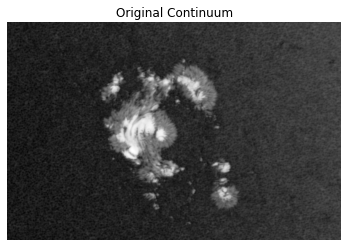

In [67]:
plt.imshow(cont, cmap = cmap)
plt.axis(False)
plt.title("Original Continuum")
plt.savefig("./outputs/continuum/cont_original.png")
plt.show()

# The Algorithm
## Step 1 - Constrain original image between 0 and 255 so that total magnitude doesn't influence the algorithm:

We could plot this, but it would look identical to the image above because this just squeezes the values between a specified range. Matplotlib uses a color map creating a bijection between \[min, max\] to \[0, 255\] anyway

In [68]:
print(f"Original: (max, min) = ({np.max(cont)}, {np.min(cont)})")
cont_bounded = 255 * (cont - np.min(cont)) / (np.max(cont) - np.min(cont))
print(f"Bounded: (max, min) = ({np.max(cont_bounded)}, {np.min(cont_bounded)})")

Original: (max, min) = (53357.0, 4829.0)
Bounded: (max, min) = (255.0, 0.0)


## Step 2 - Use a localized adaptive threshold to filter heavily "dark" segments (umbra and penumbra combined)

# Block size is the size of the local filter (as a square). 

We are using block size equal to half of the smallest dimension of the image
So that there are 4 quadrants that we scan on the image. The block size needs to be
an odd number


In [69]:
block_size = np.min(cont.shape)
if block_size % 2 == 0:
    block_size -= 1

Offset is the threshold cut off (deviation from the mean)

In [70]:
offset = 10

We will use [threshold_local](https://scikit-image.org/docs/stable/auto_examples/applications/plot_thresholding.html) from skimage filters 

In [71]:
cont_bounded[300:350][:,250:300].shape

(50, 50)

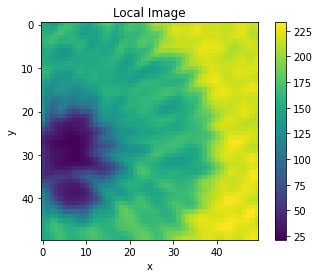

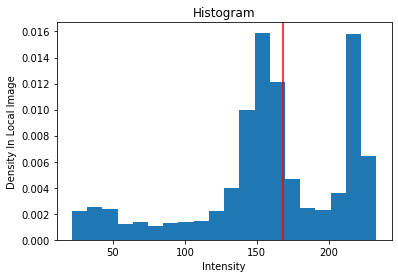

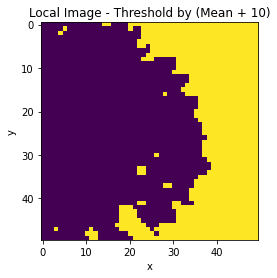

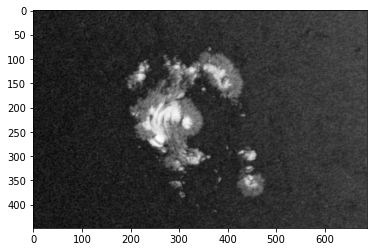

In [97]:
data = cont_bounded[200:250][:,310:360].copy()
plt.imshow(data)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Local Image")
plt.colorbar()
plt.savefig("./localnothresh.png")
plt.show()

plt.hist(data.flatten(), bins = 20, density = True)
plt.axvline(data.mean() + 10, color = "red")
plt.title("Histogram")
plt.ylabel("Density In Local Image")
plt.xlabel("Intensity")
plt.savefig("./hist.png")
plt.show()

data[(data - 10) < (data.mean())] = -1
data[data > -1] = 0
plt.imshow(data)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Local Image - Threshold by (Mean + 10)")
plt.savefig("./localthresh.png")
plt.show()

plt.imshow(cont_bounded, cmap = cmap)

In [98]:
from skimage.filters import threshold_local
binary_adaptive = cont_bounded < (threshold_local(cont_bounded, block_size, offset = offset) - offset)

The continuum segment is equal to the binary_adaptive result. We will steadily remove the penumbra from the umbra in the following steps

In [99]:
umbra_segment = binary_adaptive.copy()

The image below shows the result of applying this filter. Note that we keep all this information in the umbra, then subtract the penumbra slowly

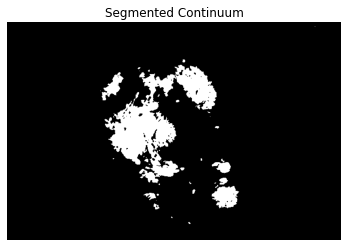

In [100]:
plt.imshow(binary_adaptive, cmap = "gray")
plt.axis(False)
plt.title("Segmented Continuum")
plt.savefig("./outputs/continuum/segments.png")
plt.show()

## Step Three - isolate each segment

There are a few axioms that we will follow to seperate penumbras and umbras:

1. Groups of less than 500 pixels are "pores" and will not be classified as penumbras
2. If we group pixels together and find that the difference between the max and min pixel value is greater than 21000, it is an umbra and penumbra combined
3. Otherwise, it is just an umbra

skimage [label](https://scikit-image.org/docs/dev/api/skimage.measure.html) function groups pixels that touch. The argument connectivity = 2 means we are also interested in diagonal pixel touching.

In [101]:
from skimage.measure import label
labeled = label(binary_adaptive, connectivity = 2).astype(float)

The plot below shows the grouped pixels

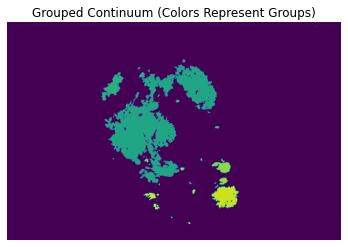

In [103]:
l_copy = labeled.copy()
l_copy[l_copy == 0] = -50 # Just to isolate the background a little more
plt.imshow(l_copy)
plt.axis(False)
plt.title("Grouped Continuum (Colors Represent Groups)")
plt.savefig("./outputs/continuum/segments_grouped.png")
plt.show()

## Step Four - Filters
The umbra mask is now set equal to the above image. The umbra does not lose these small pixels. We are filtering only to itterate through groups of pixels **to find penumbras**. 

Our next step is to itterate through all the groups to find penumbras. When we find a penumbra, **we subtract this group from the above image (umbra)**. 

In [104]:
# Remove small groups
labels = np.unique(labeled)[1:] # The first (0th index) is the background
sizes = np.array([np.count_nonzero(labeled == i) for i in labels])
filtered = np.argwhere((sizes < 500)) # Groups of less than 500 pixels
labels, sizes = np.delete(labels, filtered), np.delete(sizes, filtered) # Remove these groups from the label set

l_copy = np.full(l_copy.shape, -10)
for i in range(len(labels)):
    l_copy[labeled == labels[i]] = i

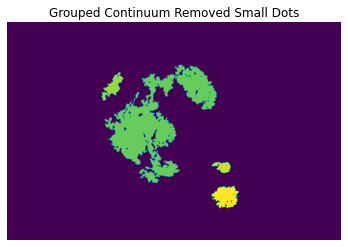

In [106]:
plt.imshow(l_copy)
plt.axis(False)
plt.title("Grouped Continuum Removed Small Dots")
plt.savefig("./outputs/continuum/segments_grouped_filtered.png")
plt.show()

## Step Five: Find Penumbras

For each group, if the range in pixel values is greater than 21000 (from experimentation), it is an umbra and penumbra combined. In this example, we only have these, there are no "isolated umbras" other than pores.

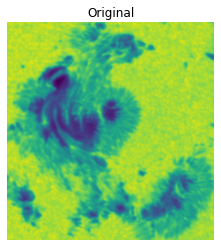

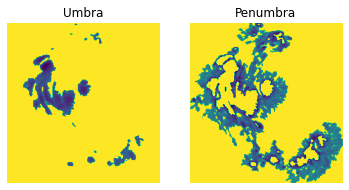

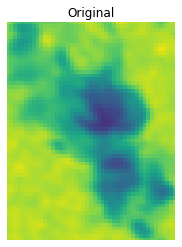

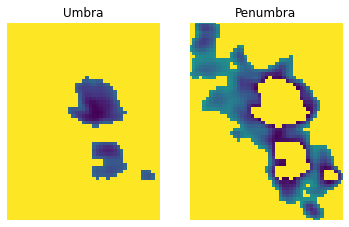

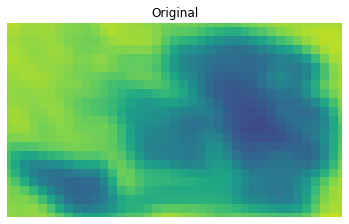

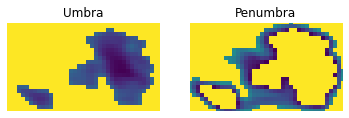

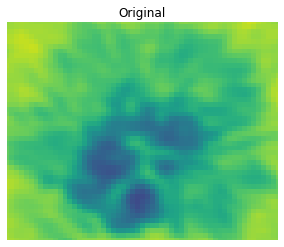

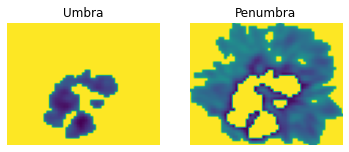

In [108]:
fill_val = np.max(cont) # Just to show the image better - I'll set "everything else" equal to the brightest pixel

penumbra_segment = np.zeros(cont.shape, dtype = bool)

for i in labels:
    mask = labeled == i
    mx = np.max(cont[mask])
    mn = np.min(cont[mask])
    
    ind = np.argwhere(mask).T
    x0, x1 = np.min(ind[1]), np.max(ind[1])
    y0, y1 = np.min(ind[0]), np.max(ind[0])
    
    t = (mx - mn) / 2 + mn
    

    
    cont_copy = cont.copy()
    plt.imshow(cont_copy)
    plt.axis(False)
    plt.title("Original")

    plt.xlim(x0, x1)
    plt.ylim(y0, y1)  
    plt.savefig(f"./outputs/continuum/small_segments/Original_{i}.png")
    plt.show()

    
    if mx - mn > 21000:
        um = mask & (cont <= t)
        pu = mask & (cont > t)
        
        # Update penumbra and umbras
        umbra_segment[pu] = False
        penumbra_segment[pu] = True       
    
        fig, (ax1, ax2) = plt.subplots(1, 2)
        
        cont_copy1 = cont.copy()
        cont_copy1[~um] = fill_val
        cont_copy2 = cont.copy()
        cont_copy2[~pu] = fill_val
        
        ax1.imshow(cont_copy1)
        ax1.axis(False)
        ax1.set_title("Umbra")
        ax1.set_xlim(x0, x1)
        ax1.set_ylim(y0, y1)
        
        ax2.imshow(cont_copy2)
        ax2.axis(False)
        ax2.set_title("Penumbra")
        ax2.set_xlim(x0, x1)
        ax2.set_ylim(y0, y1)        
        
        plt.savefig(f"./outputs/continuum/small_segments/segments_{i}.png")
        plt.show()
    else:
        cont_copy = cont.copy()
        cont_copy[~mask] = fill_val
        
        fig, (ax1, ax2) = plt.subplots(1, 2)
        
        ax1.imshow(cont_copy)
        ax1.axis(False)
        ax1.set_title("Umbra")
        ax1.set_xlim(x0, x1)
        ax1.set_ylim(y0, y1)
        
        plt.show()

## The final two segments: Umbra and Penumbra

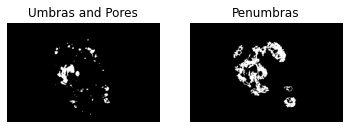

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(umbra_segment, cmap = "gray")
ax1.axis(False)
ax1.set_title("Umbras and Pores")

ax2.imshow(penumbra_segment, cmap = "gray")
ax2.axis(False)
ax2.set_title("Penumbras")
plt.savefig("outputs/continuum/umbra_penumbra.png")
plt.show()

Date =  2017-09-06 12:00:00
Harpnumber =  7115
Data Products:  dict_keys(['Bz', 'By', 'Bx', 'cont', 'sharps'])


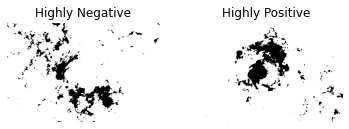

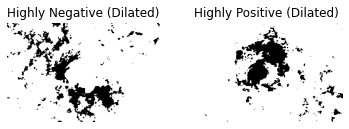

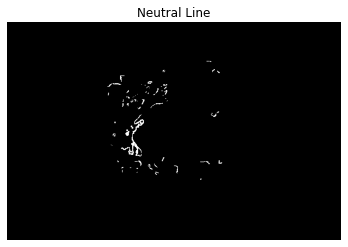

In [109]:
import numpy as np
from flares.data import get_data, get_dates
import matplotlib.pyplot as plt

cmap = "Greys"


hnum = 7115
root = "../example_data/raw"
dates = get_dates(hnum, root)
date = dates[1]
print("Date = ", date)
print("Harpnumber = ", hnum)



data = get_data(hnum, date, root)
print("Data Products: ", data.keys())
Bz = data["Bz"] # We are only interested in the continuum for now

fig, (ax1, ax2) = plt.subplots(1, 2)

pos, neg = Bz > 150, Bz < -150

ax1.imshow(neg, cmap = cmap)
ax1.set_title("Highly Negative")
ax1.axis(False)
ax2.imshow(pos, cmap = cmap)
ax2.set_title("Highly Positive")
ax2.axis(False)

plt.savefig("./outputs/neutralline/posneg.png")
plt.show()

from skimage.morphology import square, binary_dilation

fig, (ax1, ax2) = plt.subplots(1, 2)

pos, neg = binary_dilation(pos, square(3)), binary_dilation(neg, square(3))

ax1.imshow(neg, cmap = cmap)
ax1.set_title("Highly Negative (Dilated)")
ax1.axis(False)
ax2.imshow(pos, cmap = cmap)
ax2.set_title("Highly Positive (Dilated)")
ax2.axis(False)

plt.savefig("./outputs/neutralline/dilated.png")
plt.show()

from skimage.morphology import square, binary_dilation

fig, (ax1) = plt.subplots(1, 1)

neutral_line = pos & neg

ax1.imshow(~neutral_line, cmap = cmap)
ax1.set_title("Neutral Line")
ax1.axis(False)

plt.savefig("./outputs/neutralline/neutralline.png")
plt.show()



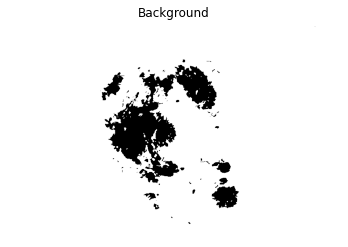

In [117]:
background = ~(umbra_segment | neutral_line | penumbra_segment)

fig, ax1 = plt.subplots(1, 1)
ax1.imshow(~background, cmap = cmap)
ax1.set_title("Background")
ax1.axis(False)
plt.savefig("./background.png")